## SparceSC

Synthetic Control via Regularized (Sparse) Optimization - Ben-Michael, Feller & Rothstein (2021)

* Ambiente virtual: venv-sparses
* https://sparsesc.readthedocs.io/en/latest/

---

***SC***

In [1]:
# -------------------------------------------------------
# SparseSC - de forma silenciosa
# -------------------------------------------------------

import sys, os
import numpy as np
import pandas as pd
import SparseSC as SC
from contextlib import redirect_stdout

# -------------------------------------------------------
# 1) Dados
# -------------------------------------------------------
df = pd.read_csv("https://github.com/Daniel-Uhr/data/raw/main/california_prop99.csv", delimiter=";")
Y = df.pivot(index="State", columns="Year", values="PacksPerCapita")
treated_idx = [Y.index.get_loc("California")]
pre  = (Y.columns <= 1988)
post = (Y.columns >  1988)

# -------------------------------------------------------
# 2) Ajuste silencioso (sem prints internos)
# -------------------------------------------------------
with open(os.devnull, "w") as f, redirect_stdout(f):
    model = SC.fit(
        features=Y.loc[:, pre].values,
        targets=Y.loc[:, post].values,
        treated_units=treated_idx
    )

# -------------------------------------------------------
# 3) ATT
# -------------------------------------------------------
Yhat_post = model.predict()
att_mean = (Y.iloc[treated_idx[0], post].values - Yhat_post[treated_idx[0], :]).mean()
print(f"ATT médio (pós-1988) — SparseSC: {att_mean:.3f}")

Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>>>>>>>>| 
ATT médio (pós-1988) — SparseSC: -24.587


c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [2]:
att_mean

-24.58738246357144

***Análise Gráfica***
* Trajetórias Real vs Sintética
* Diferença das Trajetórias

    year        real   synthetic        gap
0   1970  123.000000  112.921503  10.078497
1   1971  121.000000  116.377943   4.622057
2   1972  123.500000  122.192799   1.307201
3   1973  124.400002  122.695901   1.704100
4   1974  126.699997  124.073175   2.626822
5   1975  127.099998  125.175036   1.924963
6   1976  128.000000  128.984338  -0.984338
7   1977  126.400002  127.172497  -0.772496
8   1978  126.099998  125.255413   0.844586
9   1979  121.900002  122.258133  -0.358132
10  1980  120.199997  120.845202  -0.645205
11  1981  118.599998  120.384219  -1.784220
12  1982  115.400002  118.278950  -2.878948
13  1983  110.800003  113.777237  -2.977234
14  1984  104.800003  107.281500  -2.481497
15  1985  102.800003  105.092731  -2.292728
16  1986   99.699997  102.641763  -2.941766
17  1987   97.500000  100.566742  -3.066742
18  1988   90.099998   96.326508  -6.226510
19  1989   82.400002   92.730771 -10.330769
20  1990   77.800003   88.510111 -10.710108
21  1991   68.699997   86.141336

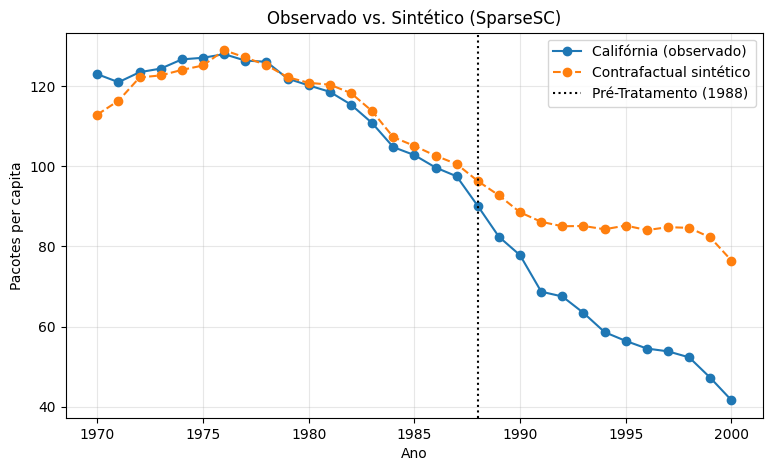

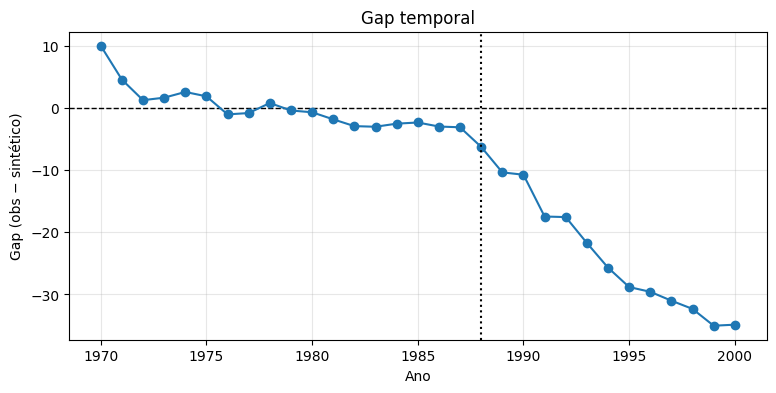

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

treated = treated_idx[0]
years   = Y.columns.to_numpy()

# 1) Pegue os índices dos controles e os pesos da unidade tratada
control_idx = np.array(model.control_units, dtype=int)  # índices das linhas de controle em Y
w = model.sc_weights[treated, :]                        # pesos do tratado sobre os controles

# 2) Reconstrua o sintético em TODO o período (pré + pós) de uma vez
Y_controls_all = Y.values[control_idx, :]               # matriz (N_ctrl x T)
Y_synth_full   = w @ Y_controls_all                     # vetor (T,)

# 3) Observado do tratado
Y_real = Y.iloc[treated, :].values

# 4) (opcional) DataFrame com série completa e gap
traj = pd.DataFrame({
    "year": years,
    "real": Y_real,
    "synthetic": Y_synth_full,
    "gap": Y_real - Y_synth_full,
})
print(traj)

# 5) Gráfico: observado vs sintético
plt.figure(figsize=(9,5))
plt.plot(years, Y_real, "-o", label="Califórnia (observado)")
plt.plot(years, Y_synth_full, "--o", label="Contrafactual sintético")
plt.axvline(1988, color="k", linestyle=":", label="Pré-Tratamento (1988)")
plt.xlabel("Ano"); plt.ylabel("Pacotes per capita"); plt.title("Observado vs. Sintético (SparseSC)")
plt.legend(); plt.grid(alpha=.3); plt.show()

# 6) (opcional) Gráfico dos gaps
plt.figure(figsize=(9,4))
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.plot(years, traj["gap"].values, "-o")
plt.axvline(1988, color="k", linestyle=":")
plt.xlabel("Ano"); plt.ylabel("Gap (obs − sintético)"); plt.title("Gap temporal")
plt.grid(alpha=.3); plt.show()


***Teste de Placebo***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from contextlib import redirect_stdout

# --- Inferência por placebos (reaproveitando seu loop) ---
N = Y.shape[0]
treated = treated_idx[0]
controls = [i for i in range(N) if i != treated]

placebo_atts = []
placebo_gaps = []   # <<— novo: guardará o gap (pré+pós) de cada placebo

for c in controls:
    # opcional: silenciar prints internos do fit
    with open(os.devnull, "w") as f, redirect_stdout(f):
        m_pl = SC.fit(
            features=Y.loc[:, pre].values,
            targets=Y.loc[:, post].values,
            treated_units=[c]
        )

    # ATT do placebo (pós), como você já fazia:
    Yhat_post_pl = m_pl.predict()
    att_pl = (Y.iloc[c, post].values - Yhat_post_pl[c, :]).mean()
    placebo_atts.append(att_pl)

    # <<— NOVO: série sintética COMPLETA para esse controle c
    ctrl_idx_pl = np.array(m_pl.control_units, dtype=int)
    w_c = m_pl.sc_weights[c, :]                     # pesos do "tratado" c sobre os controles do m_pl
    Y_controls_all_pl = Y.values[ctrl_idx_pl, :]    # (N_ctrl_pl x T)
    Y_synth_full_c = w_c @ Y_controls_all_pl        # (T,)
    diff_c = Y.iloc[c, :].values - Y_synth_full_c   # gap pré+pós do placebo c
    placebo_gaps.append(diff_c)

placebo_atts = np.array(placebo_atts)
placebo_gaps = np.vstack(placebo_gaps)              # (N_controls x T)

# Erro-padrão dos ATT placebos (como você já tinha)
std_error = placebo_atts.std(ddof=1)
t_stat = att_mean / std_error if std_error > 0 else np.nan
p_value = (np.sum(np.abs(placebo_atts) >= np.abs(att_mean)) + 1) / (len(placebo_atts) + 1)

# IC 95% normal
import scipy.stats as st
z = st.norm.ppf(0.975)
ci_norm = (att_mean - z * std_error, att_mean + z * std_error)

print(f"ATT (SC): {att_mean}")
print(f"Erro padrão (SC): {std_error}")
print(f"T-stat (SC): {t_stat}")
print(f"P-valor (SC): {p_value}")
print(f"IC 95% (normal aprox.): {ci_norm}")

# ====== Agora o gráfico estilo “State - Synthetic Across Time” ======

years = Y.columns.to_numpy()

# Gap da Califórnia com a trajetória sintética COMPLETA (reaproveitando seu modelo já estimado)
control_idx = np.array(model.control_units, dtype=int)
w_ca = model.sc_weights[treated, :]
Y_controls_all = Y.values[control_idx, :]
Y_synth_full_ca = w_ca @ Y_controls_all
gap_ca = Y.iloc[treated, :].values - Y_synth_full_ca

# Desvio-padrão ponto-a-ponto dos placebos (para filtragem opcional)
std_dev_by_t = placebo_gaps.std(axis=0, ddof=1)

plt.figure(figsize=(12, 7))

# Placebos "limpos": exclui trajetórias com |gap| > 2 sd em algum ponto
for diff_c in placebo_gaps:
    if np.all(np.abs(diff_c) <= 2 * std_dev_by_t):
        plt.plot(years, diff_c, color="gray", alpha=0.35, linewidth=0.8)

# Califórnia por cima
plt.plot(years, gap_ca, label="California", color='blue', linewidth=1.8)

plt.axvline(x=1988, color='black', linestyle=":", lw=0.9, label="Proposition 99 (1989+)")
plt.axhline(y=0, color='black', lw=1)
plt.ylabel("Gap (observado − sintético), pacotes per capita")
plt.title("State − Synthetic Across Time (SparseSC placebos reaproveitados)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\.venv-sparses\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


>>>>>>>>>>>| 


***Event-Study***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# --- Efeitos anuais (gap da Califórnia já calculado) ---
tau_t = gap_ca
years = np.array(years)
treat_year = 1989

# --- Gap médio e desvio padrão dos placebos por ano ---
sd_t = placebo_gaps.std(axis=0, ddof=1)
ci_low = tau_t - 1.96 * sd_t
ci_high = tau_t + 1.96 * sd_t

# --- Eixo de tempo relativo ao tratamento ---
event_time = years - treat_year

# --- Gráfico estilo Event-Study ---
plt.figure(figsize=(10,6))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linestyle="--", label="Tratamento (1989)")

plt.fill_between(event_time, ci_low, ci_high, color='skyblue', alpha=0.3, label="IC 95% (placebos)")
plt.plot(event_time, tau_t, '-o', color='blue', label="Gap observado (Califórnia - Sintético)")

plt.xlabel("Tempo relativo ao tratamento (anos)")
plt.ylabel("Diferença em vendas per capita (pacotes)")
plt.title("Event Study – Controle Sintético (California Prop 99)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()